In [1]:
# Enable outputting results interactively. 
# All the results from code in a given cell will be displayed instead of only the last one.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import json
import pickle
import numpy as np
import scipy.stats as stats
import sqlite3
import math
import datetime
import matplotlib.dates as mdates


from re import sub
from decimal import Decimal

import re

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()



#### Construct time series of supplies

1. Limited to short term private rooms only.

In [3]:
def supply_func(city):
    
    listings_0 =  pickle.load( open( f"../data/all_{city}_listings.p", "rb" ) )
    
#     Filtered to private rooms.

    listings_0 = listings_0[listings_0['room_type'] == 'Private room']

    # Flag listings of which the min. nights is less than 30 days. Rentals of 30 days and above are not subject to the new regulations.

    # boolean values;

    listings_0['short_term'] = (listings_0['minimum_nights']<30) * 1 
    listings_0['long_term'] = (listings_0['minimum_nights']>=30) * 1

    listings_0['scraped_dt2'] = pd.to_datetime(listings_0['file_scraped_dt'])
    listings_0 = listings_0.drop('file_scraped_dt',axis = 1)
    listings_0.columns = ['file_scraped_dt' if x=='scraped_dt2' else x for x in listings_0.columns]

    listings_0['scraped_year'] = listings_0['file_scraped_dt'].dt.year 

    listings_t = listings_0.set_index(pd.DatetimeIndex(listings_0['file_scraped_dt']))

    listings_short = listings_t[listings_t['short_term'] == 1]
    
#     get unique listing IDs of short-term private rooms

    ls_id = list(listings_short['id'].unique())

    m_ls = listings_short.resample('D').size().reset_index(name = f"{city}_counts") 

    listings_short_avail = listings_short[listings_short['availability_90'] > 0]
    

    pd.reset_option('mode.chained_assignment')
    with pd.option_context('mode.chained_assignment', None):
    
        listings_short_avail['price_float'] = listings_short_avail['price'].str.replace("\$|,", "").astype(float)

    m_ls_avail = listings_short_avail.resample('D').size().reset_index(name= f"{city}_counts") 

    return m_ls, m_ls_avail, listings_short_avail, ls_id

In [4]:
monthly_supply_portland, monthly_supply_avail_portland, ls_short_avail_portland,ls_id_portland = supply_func("Portland")

In [5]:
monthly_supply_sf, monthly_supply_avail_sf, ls_short_avail_sf, ls_id_sf = supply_func("SF")

In [6]:
monthly_supply_portland.shape, monthly_supply_sf.shape

((1593, 2), (1527, 2))

In [7]:
def chart_supplies(df_port, df_sf, title, img):
    
    comp_supply = df_port.merge(df_sf, on = 'file_scraped_dt', how = 'outer')
   
    comp_supply = comp_supply.set_index(pd.DatetimeIndex(comp_supply['file_scraped_dt']))
    comp_supply = comp_supply['2015-09-01':]
    comp_supply = comp_supply[:'2019-06-30']


    xlinspace = pd.date_range('2015-09-01', periods= comp_supply.shape[0], freq='D')

    fig, ax = plt.subplots(1,figsize = (15,8))
    fig.autofmt_xdate()
    plt.scatter(xlinspace,comp_supply['SF_counts'], label = "San Francisco")
    plt.scatter(xlinspace,comp_supply['Portland_counts'], label = "Portland")

        
    # Deadline of compliance with regulation in SF
    
    cutoff =  datetime.date(2018,1,16)
    plt.axvline(x= cutoff, color = 'red', linestyle='--', label= 'SF Regulation Compliance Deadline')
  


    ax.set_ylim(0,4000)
    plt.xlabel("Date")
    plt.ylabel("Number of Bookings")
    plt.title(title, fontsize = 18)
    plt.legend()

    xfmt = mdates.DateFormatter('%m-%d-%y')
    plt.savefig(img)

    plt.show();
    
   
    
    return comp_supply

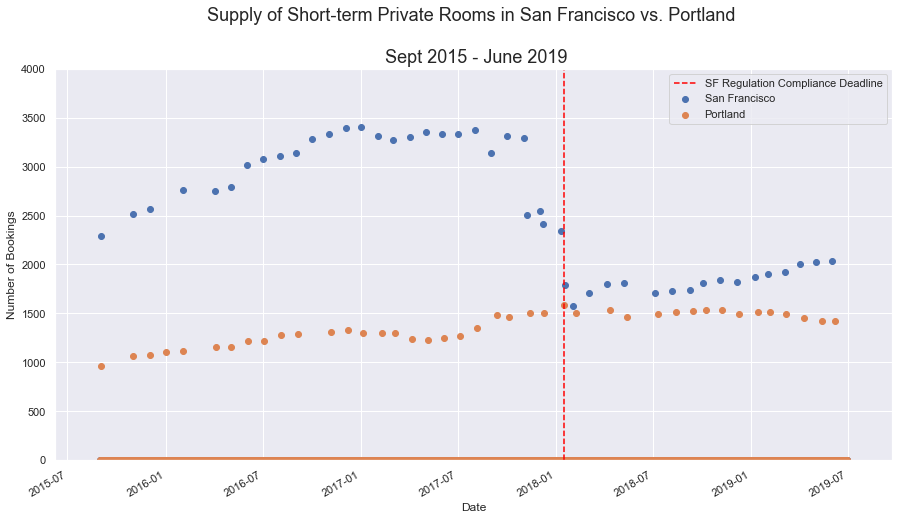

In [8]:
comp_supply_all = chart_supplies(monthly_supply_portland, monthly_supply_sf,
               "Supply of Short-term Private Rooms in San Francisco vs. Portland \n \n Sept 2015 - June 2019",
                                '../images/comp_supply_all.png')


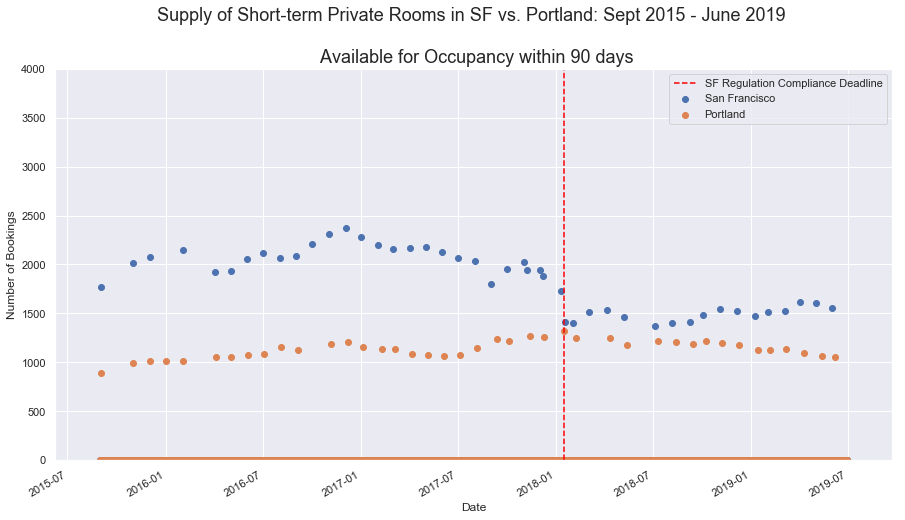

In [9]:
comp_supply_avail = chart_supplies(monthly_supply_avail_portland, monthly_supply_avail_sf, 
               
    "Supply of Short-term Private Rooms in SF vs. Portland: Sept 2015 - June 2019 \n \n Available for Occupancy within 90 days",
                                  
    '../images/comp_supply_90D_avail.png')

In [10]:
comp_supply_avail.to_csv("../data/comp_supply_avail.csv")

#### Construct time series of quantities demanded at equilibrium

1. Use frequency of reviews as a proxy of occupancies.

2. Limited to short-term private rooms only. Room type is not available in the Reviews data. Therefore we need to link it to the Listings data.

3. Key assumption: the ratio of occupany/reservation over number of reviews is constant in SF and Portland.


In [11]:
def weekly_qty(city,ls_id):
    
    reviews =  pickle.load( open( f"../data/all_{city}_reviews.p", "rb" ) )
    
    print(reviews.shape)
    
#     filtered to IDs associated with short-term private room listings.

    reviews = reviews[reviews['listing_id'].isin(ls_id)]
    
#     IDs of the listings that have ever been booked/reviewed.

    qty_id = list(reviews['listing_id'].unique())
    print(len(qty_id))
    print(reviews.shape)
    reviews = reviews.set_index(pd.DatetimeIndex(reviews['date']))

    reviews_tab = reviews.resample('W').size().reset_index(name=f"{city}_counts") 
    reviews_tab = reviews_tab.set_index(pd.DatetimeIndex(reviews_tab['date']))

    reviews_tab_post2015 = reviews_tab['2015-09-01':]
    
    return reviews_tab_post2015, qty_id

In [12]:
weekly_qty_sf, qty_id_sf = weekly_qty("SF",ls_id_sf)
weekly_qty_portland, qty_id_portland = weekly_qty('Portland',ls_id_portland)

(676599, 6)
8554
(339335, 6)
(563298, 6)
3786
(202480, 6)


In [13]:
weekly_qty_sf.shape, weekly_qty_portland.shape

((201, 2), (202, 2))

In [14]:
comp_weekly_qty = weekly_qty_portland.merge(weekly_qty_sf, on = 'date', how = 'outer')

In [15]:
comp_weekly_qty = comp_weekly_qty.iloc[:-2]

comp_weekly_qty.to_csv("../data/comp_weekly_qty.csv")

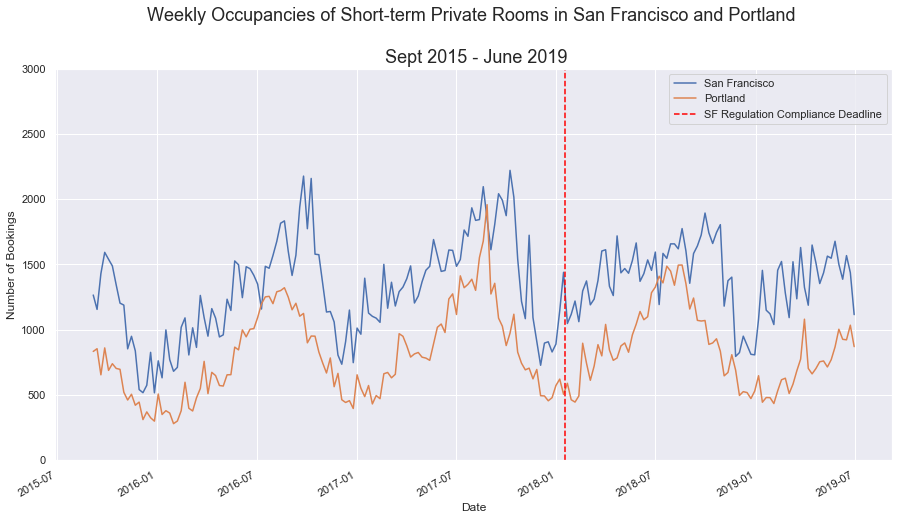

In [16]:
xlinspace = pd.date_range('2015-09-01', periods= comp_weekly_qty.shape[0], freq='W')

fig, ax = plt.subplots(1,figsize = (15,8))
fig.autofmt_xdate()
plt.plot(xlinspace,comp_weekly_qty['SF_counts'], label = "San Francisco")
plt.plot(xlinspace,comp_weekly_qty['Portland_counts'], label = "Portland")

# Deadline of compliance with regulation in SF

plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--',label='SF Regulation Compliance Deadline')


ax.set_ylim(0,3000)
plt.xlabel("Date")
plt.ylabel("Number of Bookings")
plt.title("Weekly Occupancies of Short-term Private Rooms in San Francisco and Portland \n \n Sept 2015 - June 2019", fontsize = 18)
plt.legend()

xfmt = mdates.DateFormatter('%m-%d-%y')

plt.savefig('../images/weekly_qty_comp.png')

plt.show();



#### Constructed time series of price

1. Limited to private rooms only

2. "Sticker price" in the Listings data

In [17]:
def price_series(city_df,city,qty_id):

#     private_room = city_df.loc[city_df['room_type'] == 'Private room']

# filtered to listings that have ever been reviewed.
    private_room = city_df[city_df['id'].isin(qty_id)]
    PR_p = np.asarray(private_room['price_float'])

    PR_1pct = np.percentile(PR_p, 1)
    PR_99pct = np.percentile(PR_p, 99)

    PR_1pct, PR_99pct

    # private_room = private_room[private_room['price_float'] <= PR_99pct ]
    # private_room_portland = private_room_portland[private_room_portland['price_float'] >= PR_1pct ]
    price_t = private_room.set_index(pd.DatetimeIndex(private_room['file_scraped_dt']))
    
#     avg_price = private_room.resample('D').size().reset_index(name= f"{city}_counts") 
    
    grouper = private_room.groupby(pd.Grouper(key='file_scraped_dt', freq='1D'))
    avg_price = grouper['price_float'].mean().reset_index(name = f"{city}_avg_price")
    
    return avg_price

In [18]:
avg_price_sf = price_series(ls_short_avail_sf, "SF",qty_id_sf)

In [19]:
avg_price_portland = price_series(ls_short_avail_portland, "Portland",qty_id_portland)

In [20]:
comp_price = avg_price_portland.merge(avg_price_sf, on = 'file_scraped_dt', how='outer')

In [21]:
comp_price = comp_price.set_index(pd.DatetimeIndex(comp_price['file_scraped_dt']))
comp_price = comp_price['2015-09-01':]
comp_price = comp_price[:'2019-06-30']

In [22]:
def chart_prices(df):
   

    xlinspace = pd.date_range('2015-09-01', periods= df.shape[0], freq='D')

    fig, ax = plt.subplots(1,figsize = (15,8))
#     fig.autofmt_xdate()
#     plt.scatter(xlinspace,comp_price['SF_avg_price'], label = "San Francisco")
#     plt.scatter(xlinspace,comp_price['Portland_avg_price'], label = "Portland")

    sns.lineplot(x= 'file_scraped_dt', y='SF_avg_price', data = df, label = "San Francisco")
    sns.lineplot(x= 'file_scraped_dt', y='Portland_avg_price', data = df, label = "Portland")
    
    # Deadline of compliance with regulation in SF

    plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--',label='SF Regulation Compliance Deadline')


    ax.set_ylim(0,250)
    plt.xlabel("Date")
    plt.ylabel("Price $")
    plt.title("Average Price of Private Room Listings in SF vs Portland: \n \n Sept 2015 - June 2019", fontsize = 18)
    plt.legend()

    xfmt = mdates.DateFormatter('%m-%d-%y')


    plt.show();

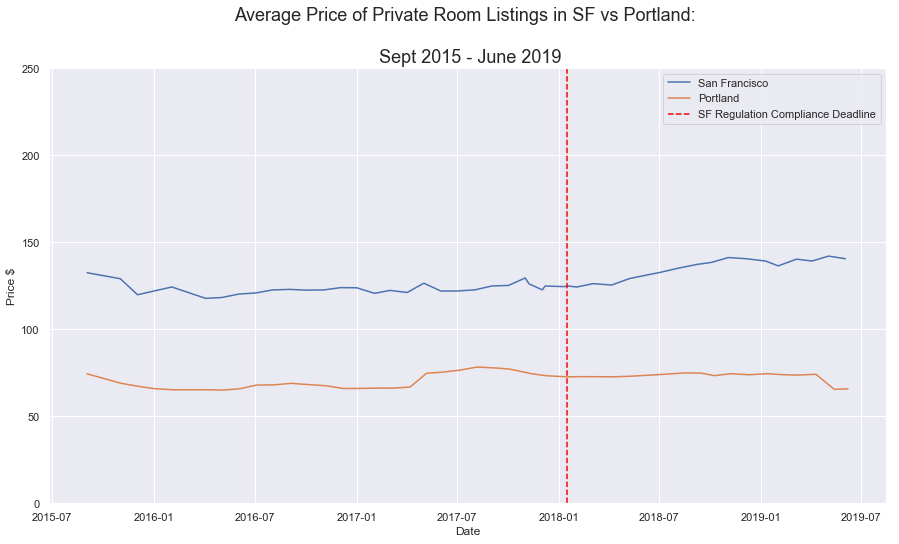

In [23]:
chart_prices(comp_price)

#### 1. Use prices reflected in the Calendar data.

In [24]:
def weighted_price(city,ls_short_avail, id_city,clip = True, calc = 'mean'):

    calendar =  pickle.load( open( f"../data/all_{city}_calendar.p", "rb" ) )
    calendar = calendar[calendar['lead_time']<= 90]
  
# short-term listings on any given day

    ls_dt_id = ls_short_avail.groupby(['file_scraped_dt','id']).size().reset_index()


    calendar = calendar.merge(ls_dt_id, left_on = ['file_scraped_dt','listing_id'], \
                              right_on = ['file_scraped_dt','id'], how = 'inner')
    
#     filtered to listings that have ever been booked/reviewed
    
    calendar_pr_short = calendar[calendar['listing_id'].isin(id_city)]

    pd.reset_option('mode.chained_assignment')
    with pd.option_context('mode.chained_assignment', None):
        calendar_pr_short['price_float'] = calendar_pr_short['price'].str.replace("\$|,", "").astype(float)

    calendar_pr_short = calendar_pr_short[~calendar_pr_short['price'].isnull()]

    PR_p = np.asarray(calendar_pr_short['price_float'])

    PR_1pct = np.percentile(PR_p, 1)
    PR_99pct = np.percentile(PR_p, 99)
    PR_50pct = np.percentile(PR_p, 50)

    print(PR_1pct, PR_50pct, PR_99pct)

    if calc == 'mean':
        if clip == True:
        
            calendar_pr_short = calendar_pr_short[calendar_pr_short['price_float'] <= PR_99pct]
            calendar_pr_short = calendar_pr_short[calendar_pr_short['price_float'] >= PR_1pct]
        else:
            calendar_pr_short = calendar_pr_short.copy()
    

        avg_price = calendar_pr_short.groupby(['listing_id','date'])['price_float'].mean().reset_index()

        grouper = avg_price.groupby(pd.Grouper(key='date', freq='1W'))
        avg_price = grouper['price_float'].mean().reset_index(name = f"{city}_avg_price")
    
        daily_avg_price = calendar_pr_short.groupby(['listing_id','date'])['price_float'].mean().reset_index()
        daily_avg_price = daily_avg_price.groupby(['date'])['price_float'].mean().reset_index()
        daily_avg_price.to_csv(f"../data/daily_avg_price_{city}.csv")
        
        return avg_price, PR_p
    elif calc == 'median':
        avg_price = calendar_pr_short.groupby(['listing_id','date'])['price_float'].mean().reset_index()

        grouper = avg_price.groupby(pd.Grouper(key='date', freq='1W'))
        median_price = grouper['price_float'].median().reset_index(name = f"{city}_median_price")
        
        return median_price, PR_p

    
    

In [25]:
avg_price_sf, PR_p_sf = weighted_price("SF", ls_short_avail_sf, qty_id_sf, clip = True)
avg_price_portland,  PR_p_portland = weighted_price("Portland",  ls_short_avail_portland, qty_id_portland, clip=True)

comp_avg_price = avg_price_portland.merge(avg_price_sf, on = 'date', how = 'outer')

comp_avg_price = comp_avg_price.set_index(pd.DatetimeIndex(comp_avg_price['date']))
comp_avg_price = comp_avg_price['2015-09-01':]
comp_avg_price = comp_avg_price[:'2019-06-30']

comp_avg_price.to_csv("../data/mean_comp_price.csv")

49.0 115.0 475.0
26.0 62.0 185.0


In [26]:
def chart_prices2(df, calc = 'mean'):
   

    xlinspace = pd.date_range('2015-09-01', periods= df.shape[0], freq='W')

    fig, ax = plt.subplots(1,figsize = (15,8))

    sns.lineplot(x= 'date', y='SF_avg_price', data = df, label = "San Francisco")
    sns.lineplot(x= 'date', y='Portland_avg_price', data = df, label = "Portland")
    
    # Deadline of compliance with regulation in SF

    plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--',label='SF Regulation Compliance Deadline')


    ax.set_ylim(0,250)
    plt.xlabel("Date")
    plt.ylabel("Price $")
    
    
    plt.title("Weekly Average Price of Private Room Listings in SF vs Portland: \n \n Sept 2015 - June 2019", fontsize = 18)
    plt.legend()

    xfmt = mdates.DateFormatter('%m-%d-%y')


    plt.show();


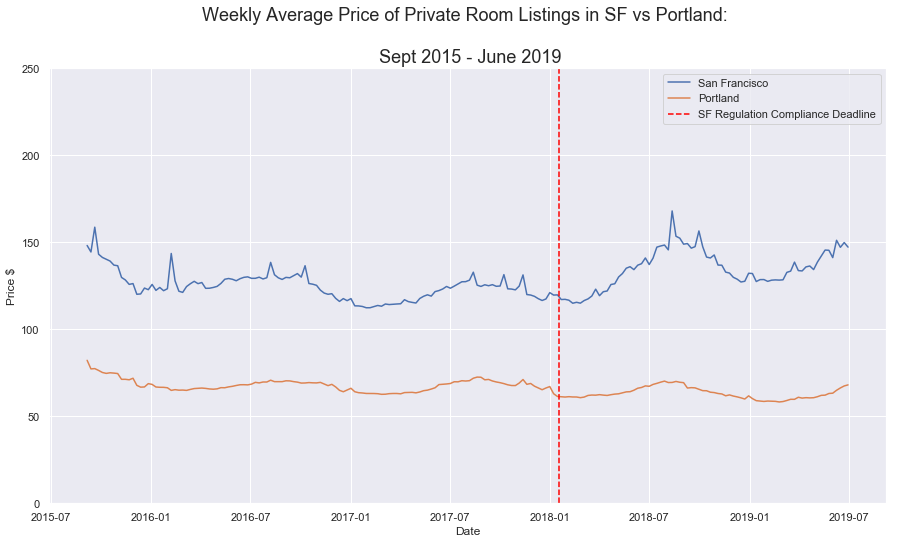

In [27]:
chart_prices2(comp_avg_price)

In [28]:


median_price_sf, PR_p_sf = weighted_price("SF", ls_short_avail_sf, qty_id_sf, clip = False, calc = 'median')
median_price_portland,  PR_p_portland = weighted_price("Portland",  ls_short_avail_portland, qty_id_portland, clip=False, calc = 'median')

comp_median_price = median_price_portland.merge(median_price_sf, on = 'date', how = 'outer')

comp_median_price = comp_median_price.set_index(pd.DatetimeIndex(comp_median_price['date']))
comp_median_price = comp_median_price['2015-09-01':]
comp_median_price = comp_median_price[:'2019-06-30']

comp_median_price.to_csv("../data/median_comp_price.csv")


49.0 115.0 475.0
26.0 62.0 185.0


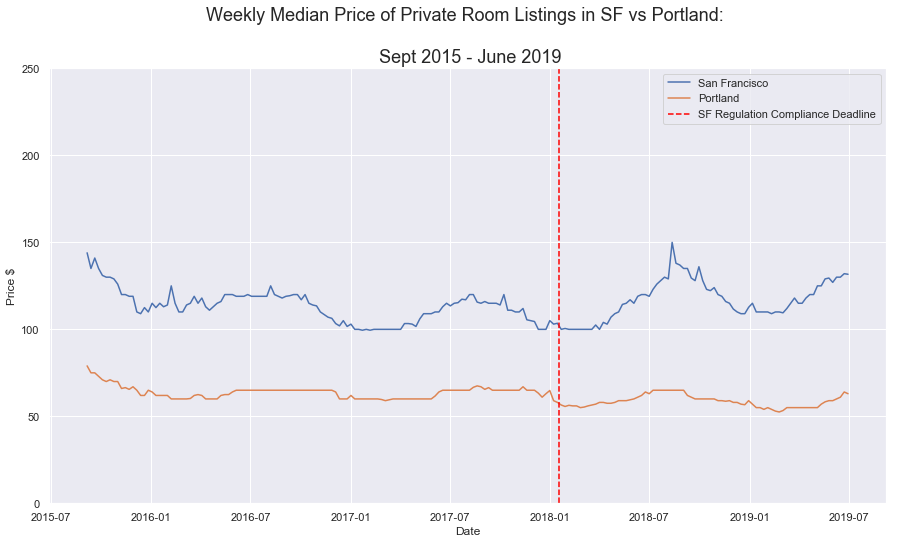

In [29]:
def chart_prices3(df):
   

    xlinspace = pd.date_range('2015-09-01', periods= df.shape[0], freq='W')

    fig, ax = plt.subplots(1,figsize = (15,8))

    sns.lineplot(x= 'date', y='SF_median_price', data = df, label = "San Francisco")
    sns.lineplot(x= 'date', y='Portland_median_price', data = df, label = "Portland")
    
    # Deadline of compliance with regulation in SF

    plt.axvline(x= datetime.date(2018,1,16), color = 'red', linestyle='--',label='SF Regulation Compliance Deadline')


    ax.set_ylim(0,250)
    plt.xlabel("Date")
    plt.ylabel("Price $")
    plt.title("Weekly Median Price of Private Room Listings in SF vs Portland: \n \n Sept 2015 - June 2019", fontsize = 18)
    plt.legend()

    xfmt = mdates.DateFormatter('%m-%d-%y')
    
    plt.savefig('../images/weekly_median_price_comp.png')

    plt.show();
    
   

chart_prices3(comp_median_price)

##### Construct weekly median price series by neighborhood in SF.

In [30]:
calendar =  pickle.load( open( f"../data/all_SF_calendar.p", "rb" ) )
calendar = calendar[calendar['lead_time']<= 90]
  
# short-term listings on any given day

ls_dt_id = ls_short_avail_sf.groupby(['file_scraped_dt','id']).size().reset_index()


calendar = calendar.merge(ls_dt_id, left_on = ['file_scraped_dt','listing_id'], \
                              right_on = ['file_scraped_dt','id'], how = 'inner')
    
#     filtered to listings that have ever been booked/reviewed
    
calendar_pr_short = calendar[calendar['listing_id'].isin(qty_id_sf)]

pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    calendar_pr_short['price_float'] = calendar_pr_short['price'].str.replace("\$|,", "").astype(float)

calendar_pr_short.shape

calendar_pr_short = calendar_pr_short[~calendar_pr_short['price'].isnull()]

calendar_pr_short.shape

(4120226, 12)

(4120226, 12)

In [31]:
# grouper = avg_price_ls.groupby(pd.Grouper(key='date', freq='1W'))
# tmp = grouper['price_float'].size().reset_index()
# tmp.head()


In [32]:
# avg_price_ls = avg_price_ls.sort_values(by='date')
# avg_price_ls.head()

# avg_price_ls['date'] = pd.to_datetime(avg_price['date'])
# test = avg_price_ls[(avg_price['date'] <= pd.Timestamp(2015,5,10))]
# test.shape
# the date representing a week includes a Sunday and the preceding days.
# e.g. week of 2015-5-10 includes 2015-5-4 to 2015-5-10 

In [33]:
ls_loc = pd.read_pickle('../data/listings_loc.p')
ls_loc = ls_loc[['listing_id', 'std_nb']]
ls_loc.head()

neighbourhood_cleansed,listing_id,std_nb
0,958,Western Addition
1,2822,Bayview
2,5021,Castro/Upper Market
3,5193,Nob Hill
4,5841,Mission


In [34]:
calendar_daily_loc = calendar_pr_short.merge(ls_loc, on = 'listing_id', how = 'left')
calendar_daily_loc.shape

(4120226, 13)

In [35]:
tmp = calendar_daily_loc[calendar_daily_loc['std_nb'].isnull()]
missing_loc = list(tmp.listing_id.unique())


In [36]:
listings_0 =  pickle.load( open( f"../data/all_SF_listings.p", "rb" ) )

tmp2 = listings_0[listings_0['id'].isin(missing_loc)]


In [37]:
filled_loc = tmp2.groupby(['id','neighbourhood_cleansed']).size().reset_index(name='counts')
filled_loc = filled_loc.drop('counts', axis = 1)
filled_loc.columns = ['listing_id', 'std_nb_filled']
filled_loc.head()

,listing_id,std_nb_filled
0,3850,Inner Sunset
1,50367,Nob Hill
2,56222,South of Market
3,102477,Castro/Upper Market
4,184548,Bernal Heights


In [38]:
calendar_daily_loc = calendar_daily_loc.merge(filled_loc, on = 'listing_id', how = 'left')
calendar_daily_loc.shape

(4120226, 14)

In [39]:
calendar_daily_loc[calendar_daily_loc['std_nb_filled'].notnull()]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,file_scraped_dt,lead_time,id,0,price_float,std_nb,std_nb_filled
0,3850,2019-07-14,t,$79.00,$79.00,1.0,5.0,2019-07-08,6,3850,1,79.0,NaN,Inner Sunset
1,3850,2019-07-15,t,$79.00,$79.00,1.0,5.0,2019-07-08,7,3850,1,79.0,NaN,Inner Sunset
2,3850,2019-07-18,t,$79.00,$79.00,1.0,5.0,2019-07-08,10,3850,1,79.0,NaN,Inner Sunset
3,3850,2019-07-22,t,$79.00,$79.00,1.0,5.0,2019-07-08,14,3850,1,79.0,NaN,Inner Sunset
4,3850,2019-07-23,t,$79.00,$79.00,1.0,5.0,2019-07-08,15,3850,1,79.0,NaN,Inner Sunset
5,3850,2019-07-24,t,$79.00,$79.00,1.0,5.0,2019-07-08,16,3850,1,79.0,NaN,Inner Sunset
6,3850,2019-07-25,t,$79.00,$79.00,1.0,5.0,2019-07-08,17,3850,1,79.0,NaN,Inner Sunset
7,3850,2019-07-26,t,$79.00,$79.00,1.0,5.0,2019-07-08,18,3850,1,79.0,NaN,Inner Sunset
8,3850,2019-07-28,t,$85.00,$85.00,1.0,5.0,2019-07-08,20,3850,1,85.0,NaN,Inner Sunset
9,3850,2019-07-29,t,$85.00,$85.00,1.0,5.0,2019-07-08,21,3850,1,85.0,NaN,Inner Sunset


In [40]:
calendar_daily_loc.loc[(pd.isnull(calendar_daily_loc.std_nb)), 'std_nb'] = calendar_daily_loc['std_nb_filled']


In [41]:
tmp = calendar_daily_loc.groupby(['listing_id','std_nb']).size()
tmp2 = tmp.groupby('listing_id').size().reset_index(name='count')
tmp2.query('count >1')

# Verified that neighborhood name is 1-to-1 match to listing ID.

,listing_id,count


In [42]:


avg_price_loc = calendar_daily_loc.groupby(['listing_id','date','std_nb'])['price_float'].mean().reset_index()
weekly_median_loc = avg_price_loc.groupby(['std_nb', pd.Grouper(key='date', freq='W')])['price_float'].median().reset_index(name ='median_price')
weekly_median_loc.head()

weekly_median_loc.to_csv('../data/weekly_median_price_by_loc.csv')


,std_nb,date,median_price
0,Bayview,2015-05-10,110.0
1,Bayview,2015-05-17,100.0
2,Bayview,2015-05-24,100.0
3,Bayview,2015-05-31,101.0
4,Bayview,2015-06-07,101.0
